# Run a pre-trained Epinet on ImageNet
This demo shows how to run and evaluate a pre-trained *Epinet* on ImageNet. Epinet is a new ENN architecture that can supplement any conventional NN and be trained to estimate uncertainty.


An epinet is a neural network with privileged access to inputs and outputs of activation units in the base network.
A subset of these inputs and outputs, denoted by $\phi_\zeta(x)$, are taken as input to the epinet along with an epistemic index $z$.
For epinet parameters $\eta$, the epinet outputs $\sigma_\eta(\phi_\zeta(x), z)$.
To produce an ENN, the output of the epinet is added to that of the base network, though with a "stop gradient" written $[[\cdot]]$:

$$ f_\theta(x, z) = \mu_\zeta(x) + \sigma_\eta([[\phi_\zeta(x)]], z). $$


We can visualize this network architecture:

![epinet diagram](https://raw.githubusercontent.com/deepmind/enn/master/statics/images/epinet_new.png)

For more details about Epinet, refer to the paper 
[Epistemic Neural Networks](https://arxiv.org/abs/2107.08924) (Osband et al., 2022).

It's recommended to use `Runtime->Change Runtime Type` to pick a GPU for speed.

In [ ]:
# Copyright 2022 DeepMind Technologies Limited. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
!git clone https://github.com/deepmind/enn.git
!pip install -q enn/

## Imports

In [ ]:
#@title General imports

import warnings

warnings.filterwarnings('ignore')


#@title Development imports
from typing import Callable, NamedTuple

import numpy as np
import pandas as pd
import plotnine as gg

from acme.utils.loggers.terminal import TerminalLogger
import dataclasses
import chex
import haiku as hk
import jax
import jax.numpy as jnp
import optax
import dill

In [ ]:
#@title ENN imports
import enn
from enn import datasets
from enn.checkpoints import base as checkpoint_base
from enn.networks.epinet import base as epinet_base
from enn.checkpoints import utils
from enn.checkpoints import imagenet
from enn.checkpoints import catalog
from enn import metrics as enn_metrics

## Load ImageNet dataset

Our `enn` library provides functionalities in `enn/datasets` to load ImageNet, CIFAR10/100, and MNIST datasets. To load these datasets, you need to download that dataset into the default tensorflow dataset directory of `~/tensorflow_datasets/downloads/manual/`. 

In this colab, we want to evaluate Epinet on only one small batch of ImageNet test images. To this end, we provide a sample batch of size 100 at [https://storage.googleapis.com/dm-enn/processed_batch.npzs](https://storage.googleapis.com/dm-enn/processed_batch.npzs) which can be download as follows.

In [ ]:
!wget https://storage.googleapis.com/dm-enn/processed_batch.npzs --no-check-certificate
with open('processed_batch.npzs', 'rb') as file:
  batch = dill.load(file)
images, labels = batch['images'], batch['labels']

--2022-05-25 20:55:35--  https://storage.googleapis.com/dm-enn/processed_batch.npzs
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.214.128, 173.194.215.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60212344 (57M) [application/octet-stream]
Saving to: ‘processed_batch.npzs.1’

processed_batch.npz 100%[===================>]  57.42M  91.2MB/s    in 0.6s    

2022-05-25 20:55:36 (91.2 MB/s) - ‘processed_batch.npzs.1’ saved [60212344/60212344]



## Define a set of evaluation metrics

Our `enn` library provides the set of known metrics for evaluating the performance of neural networks. These metrics which can be access from `enn/metrics` can be divided in three categories:


1.   **Marginal**: includes metrics like accuracy and marginal negative log-likelihood (NLL) for evaluating marginal predictions.
2.   **Joint**: includes metrics for evaluating joint predictions. 
3.   **Calibration**: includes metrics for calculating calibration error.

Each metric takes logits and lables with the following shapes:
  - logits: [num_enn_samples, batch_size, num_classes]
  - labels: [batch_size, 1]

`num_enn_samples` specifies the number of sample logits per input image.


In [ ]:
# Define a dict of metrics including `accuracy`, `marginal nll`, and `joint nll`.
evaluation_metrics = {
      'accuracy': enn_metrics.make_accuracy_calculator(),
      'marginal nll': enn_metrics.make_nll_marginal_calculator(),
      'joint nll': enn_metrics.make_nll_polyadic_calculator(tau=10, kappa=2),
  }

## Load pre-trained Epinet

Pre-trained Epinet can be accessed from `ImagenetModels` in `enn.checkpointing.catalog.py`. As of now, we provide pre-trained Epinet based on ResNet-50, ResNet-101, ResNet-152, and ResNet-200. In this colab, we want to load Epinet based on ResNet-50 which can be accessed from the checkpoint `RESNET_50_FINAL_EPINET`.

In [ ]:
# Get the Epinet checkpoint
epinet_resnet50_imagenet_ckpt = catalog.ImagenetModels.RESNET_50_FINAL_EPINET.value
epinet_resnet50_imagenet_ckpt

EpinetCheckpoint(name='imagenet_final_epinet_resnet50', load_fn=<function load_from_file.<locals>.load_fn at 0x7fd9e10160e0>, epinet_ctor=<function make_checkpoint_from_config.<locals>.<lambda> at 0x7fd9e10163b0>, parse_hidden=<function parse_base_hidden at 0x7fd9f7611a70>, base_cpt=EnnCheckpoint(name='imagenet_resnet50', load_fn=<function load_from_file.<locals>.load_fn at 0x7fd9e1016170>, enn_ctor=<function _make_resnet_ctor.<locals>.enn_ctor at 0x7fd9e1016200>, dataset=Imagenet(train_ds_transformer=<function Imagenet.<lambda> at 0x7fd9f7dbd170>, eval_ds_transformers={'eval': <function <lambda>.<locals>.<lambda> at 0x7fd9e1016290>}, train_batch=128, eval_batch=100, dataset_seed=0, enable_double_transpose=True, fake_data=False, num_train=1281167), report_cl=None), base_index=None, base_scale=1.0, temperature=0.7, dataset=None, report_cl=None)

From the checkpoint, we can recover an enn sampler, which is a function that takes a batch of images and one random key, and returns multiple sample logits per input image. To recover the enn sampler, we can use `make_epinet_sampler_from_checkpoint` (from `enn/checkpoints/utils.py`) which takes the checkpoint and also the number of sample logits we want per image (`num_enn_samples`).

In [ ]:
# Set the number of sample logits per input image
num_enn_samples = 100
# Recover the enn sampler
epinet_enn_sampler = utils.make_epinet_sampler_from_checkpoint(
    epinet_resnet50_imagenet_ckpt,
    num_enn_samples=num_enn_samples,)
# Get the epinet logits
key = jax.random.PRNGKey(seed=0)
epinet_logits = epinet_enn_sampler(images, key)

In [ ]:
# epinet logits has shape [num_enn_sample, eval_batch_size, num_classes]
epinet_logits.shape

(100, 100, 1000)

In [ ]:
# Labels loaded from our dataset has shape [eval_batch_size,]. Our evaluation
# metrics requires labels to have shape [eval_batch_size, 1].
eval_labels = labels[:, None]
# Evaluate 
epinet_results = {key: float(metric(epinet_logits, eval_labels)) 
                      for key, metric in evaluation_metrics.items()}
epinet_results

{'accuracy': 0.8399999737739563,
 'joint nll': 4.127983093261719,
 'marginal nll': 0.7758241295814514}

## Load pre-trained ResNet

To have a better sense of how amazing Epinet is, we can compare its performance with a pretrained ResNet-50.

Pre-trained ResNets can be accessed from `ImagenetModels` in `enn.checkpointing.catalog.py`. As of now, we provide pre-trained ResNet-50, ResNet-101, ResNet-152, and ResNet-200. 

In [ ]:
# Get the ResNet-50 checkpoint
resnet50_imagenet_ckpt = catalog.ImagenetModels.RESNET_50.value
resnet50_imagenet_ckpt

EnnCheckpoint(name='imagenet_resnet50', load_fn=<function load_from_file.<locals>.load_fn at 0x7fd9e108a8c0>, enn_ctor=<function _make_resnet_ctor.<locals>.enn_ctor at 0x7fd9e108ab90>, dataset=Imagenet(train_ds_transformer=<function Imagenet.<lambda> at 0x7fd9f7dbd170>, eval_ds_transformers={'eval': <function <lambda>.<locals>.<lambda> at 0x7fd9e108aef0>}, train_batch=128, eval_batch=100, dataset_seed=0, enable_double_transpose=True, fake_data=False, num_train=1281167), report_cl=None)

From the checkpoint, we can recover an enn sampler, which is a function that takes a batch of images and one random key, and returns multiple sample logits per input image. To recover the enn sampler for ResNet-50, we can use `make_enn_sampler_from_checkpoint` (from `enn/checkpoints/utils.py`) which takes the checkpoint and also the number of sample logits we want per image (`num_enn_samples`). Here we set `num_enn_samples=1`, as having `num_enn_samples > 1` just results in multiple similar sample logits per input image.

In [ ]:
# Set the number of sample logits per input image to 1
num_enn_samples = 1
# Recover the enn sampler
resnet50_enn_sampler = utils.make_enn_sampler_from_checkpoint(
    resnet50_imagenet_ckpt,
    num_enn_samples=num_enn_samples,)
# Get the epinet logits
key = jax.random.PRNGKey(seed=0)
resnet50_logits = resnet50_enn_sampler(images, key)

In [ ]:
# ResNet logits has shape [num_enn_sample, eval_batch_size, num_classes]
resnet50_logits.shape

(1, 100, 1000)

In [ ]:
# Labels loaded from our dataset has shape [eval_batch_size,]. Our evaluation
# metrics requires labels to have shape [eval_batch_size, 1].
eval_labels = labels[:, None]
# Evaluate 
resnet50_results = {key: float(metric(resnet50_logits, eval_labels)) 
                      for key, metric in evaluation_metrics.items()}
resnet50_results

{'accuracy': 0.8399999737739563,
 'joint nll': 8.023576736450195,
 'marginal nll': 0.7877810597419739}

## Compare Epinet and ResNet results

In [ ]:
# Make a dataframe of the results
resnet50_results['model'] = 'resnet'
epinet_results['model'] = 'epinet'
df = pd.DataFrame([resnet50_results, epinet_results])
df

,accuracy,marginal nll,joint nll,model
0,0.84,0.787781,8.023577,resnet
1,0.84,0.775824,4.127983,epinet


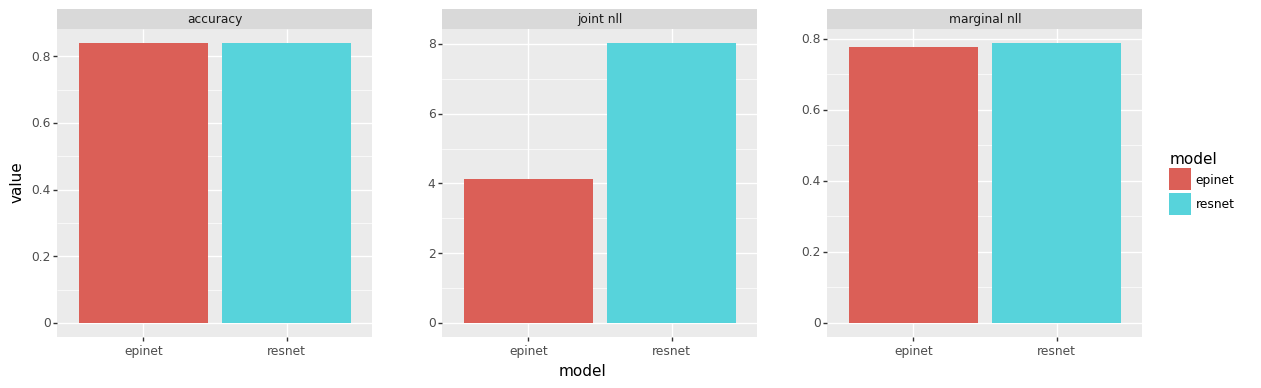

<ggplot: (8785860638037)>

In [ ]:
# Compare the results
plt_df = pd.melt(df, id_vars=['model'], value_vars=evaluation_metrics.keys())
p = (gg.ggplot(plt_df)
    + gg.aes(x='model', y='value', fill='model') 
    + gg.geom_col()
    + gg.facet_wrap('variable', scales='free',)
    + gg.theme(figure_size=(14, 4), panel_spacing=0.7)
    )
p